In [39]:
import wandb

In [40]:
import os
os.environ.get("LD_LIBRARY_PATH")

In [41]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/cluster_features_GT_clusters/cluster_features"
    r = {}
    n = 0
    nmax = 257
    for file in os.listdir(path):
        n += 1
        if n > nmax:
            break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    print("x shape:", r["x"].shape)
    return r["x"], x_names, r["true_e_corr"], r["e_true"], r["e_reco"]

def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _ = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest = train_test_split(
        x, y, etrue, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model
def main():
    ds = get_dataset()
    print("Loaded dataset")
    split = get_split(ds)
    gpus = [0]
    wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        result = model.fit(split[0], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError


CUDA available: True


In [43]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})


In [44]:
yt, yp, en, _, model, split = main()

x shape: torch.Size([24781, 8])
Loaded dataset


      Iter       Train Loss   Remaining Time 
         1          19.3082            3.54s
         2          15.9700            3.47s
         3          13.2574            3.49s
         4          11.0158            3.45s
         5           9.1978            3.40s
         6           7.7206            3.36s
         7           6.5172            3.33s
         8           5.5199            3.29s
         9           4.7191            3.25s
        10           4.0498            3.21s
        20           1.3476            2.83s
        30           0.8473            2.47s
        40           0.7046            2.12s
        50           0.6114            1.76s
        60           0.5552            1.40s
        70           0.5168            1.05s
        80           0.4833            0.70s
        90           0.4502            0.35s
       100           0.4202            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


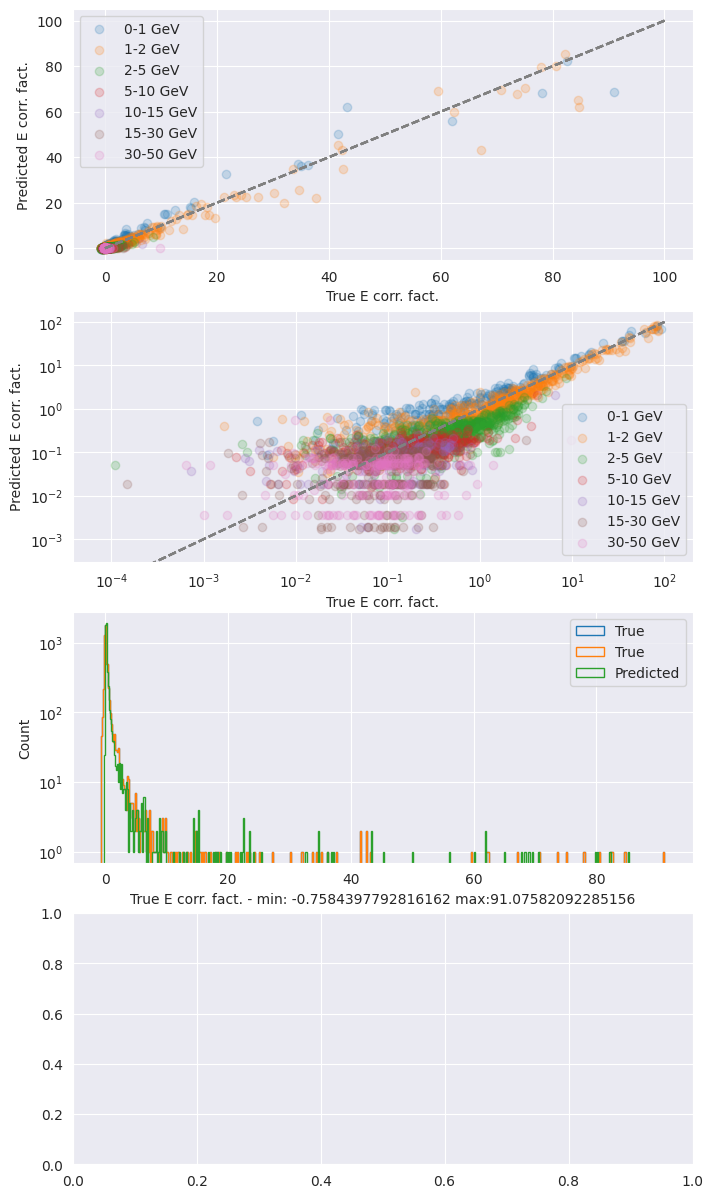

In [30]:
plot(yt, yp, en)

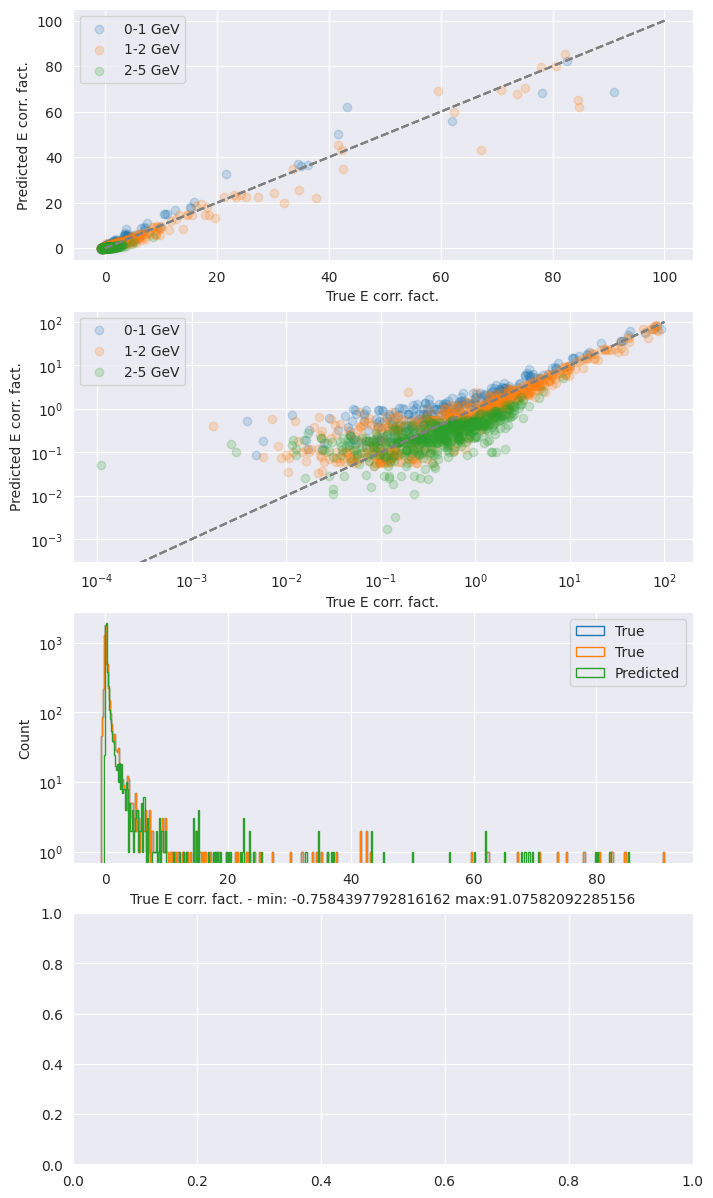

In [31]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            if i not in [0, 1, 2]:
                continue
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})
plot(yt, yp, en)

In [47]:
import shap
te = shap.TreeExplainer(model)
shap_vals = te.shap_values(np.array(split[1]))

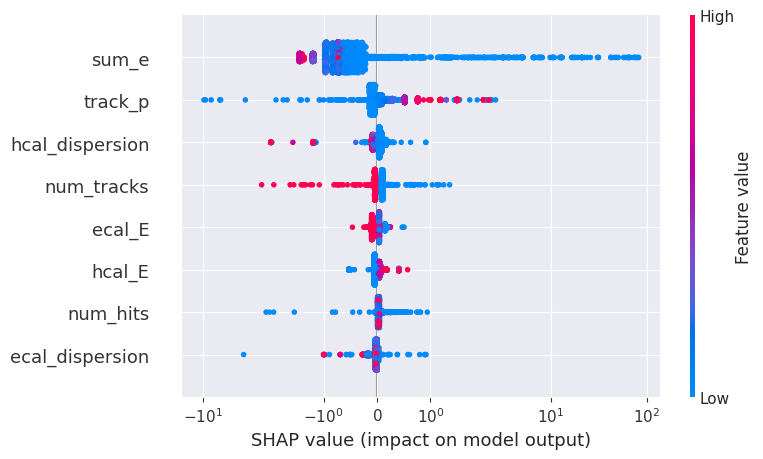

In [52]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals, split[1], feature_names=x_names, use_log_scale=True)

In [50]:
#for name in x_names:
shap.dependence_plot(name, shap_vals, split[1], display_features=["sum_e"])


ValueError: Could not find feature named: ecal_E

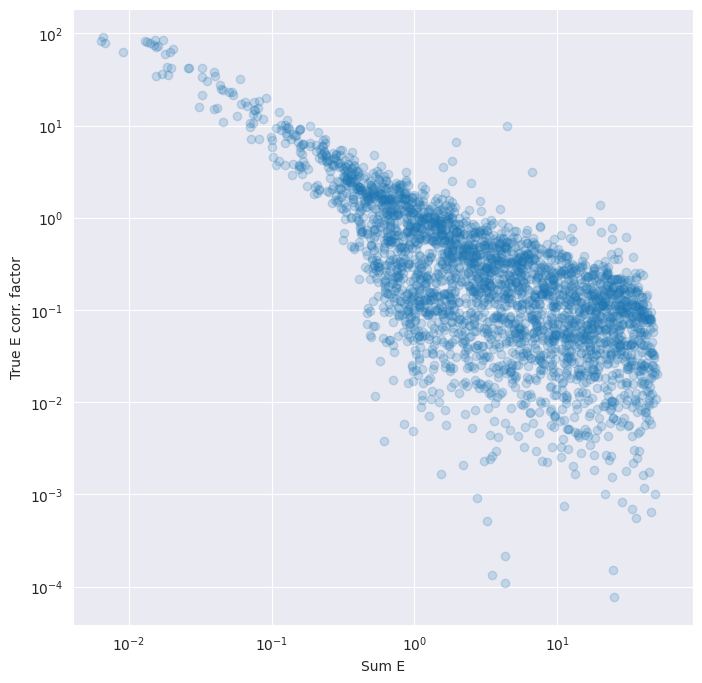

In [55]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(split[1][:, 6], yt, label="True", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("True E corr. factor")
fig.show()